In [1]:
!pip install librosa

In [2]:
!pip install imbalanced-learn

## MFCC Feature Extraction

In [3]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [8]:
DATA_PATH = 'preprocess'
SAMPLE_RATE = 16000
DURATION = 10 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
NUM_MFCC = 13


In [15]:
import os
import numpy as np
import librosa
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Parameters
DATA_DIR = 'preprocess'
SAMPLE_RATE = 16000
NUM_MFCC = 40
MAX_DURATION = 4  # seconds
MAX_LENGTH = SAMPLE_RATE * MAX_DURATION
FIXED_SIZE = (128, 128)  # final MFCC shape (height, width)

def extract_mfcc(file_path, sr=SAMPLE_RATE, num_mfcc=NUM_MFCC, fixed_size=FIXED_SIZE):
    y, _ = librosa.load(file_path, sr=sr)

    # Pad or truncate the waveform to fixed duration
    if len(y) < MAX_LENGTH:
        y = np.pad(y, (0, MAX_LENGTH - len(y)))
    else:
        y = y[:MAX_LENGTH]

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)

    # Normalize MFCCs (optional but useful for CNNs)
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)

    # Resize to fixed shape (128x128)
    mfcc_resized = cv2.resize(mfcc, fixed_size)

    return mfcc_resized

# Load and extract MFCCs
X = []
y = []

for class_name in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue

    for file in os.listdir(class_dir):
        if not file.lower().endswith('.wav'):
            continue
        file_path = os.path.join(class_dir, file)
        mfcc = extract_mfcc(file_path)
        X.append(mfcc)
        y.append(class_name)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Add channel dimension: (samples, height, width, channels)
X = X[..., np.newaxis]

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

print(f"✅ Shape of X: {X.shape}, y: {y_onehot.shape}")


✅ Shape of X: (457, 128, 128, 1), y: (457, 5)


In [16]:
X

array([[[[-4.020393  ],
         [-4.048594  ],
         [-4.303219  ],
         ...,
         [-4.053125  ],
         [-2.8894386 ],
         [-2.5113847 ]],

        [[-4.020393  ],
         [-4.048594  ],
         [-4.303219  ],
         ...,
         [-4.053125  ],
         [-2.8894386 ],
         [-2.5113847 ]],

        [[-2.243209  ],
         [-2.2411056 ],
         [-2.4497998 ],
         ...,
         [-2.8142748 ],
         [-1.9916315 ],
         [-1.718497  ]],

        ...,

        [[ 0.12555735],
         [ 0.13507001],
         [ 0.13798931],
         ...,
         [ 0.07877667],
         [ 0.08571006],
         [ 0.13536078]],

        [[ 0.1045637 ],
         [ 0.11251609],
         [ 0.12071338],
         ...,
         [ 0.02549528],
         [ 0.08427148],
         [ 0.1736673 ]],

        [[ 0.1045637 ],
         [ 0.11251609],
         [ 0.12071338],
         ...,
         [ 0.02549528],
         [ 0.08427148],
         [ 0.1736673 ]]],


       [[[-5.013652  ],


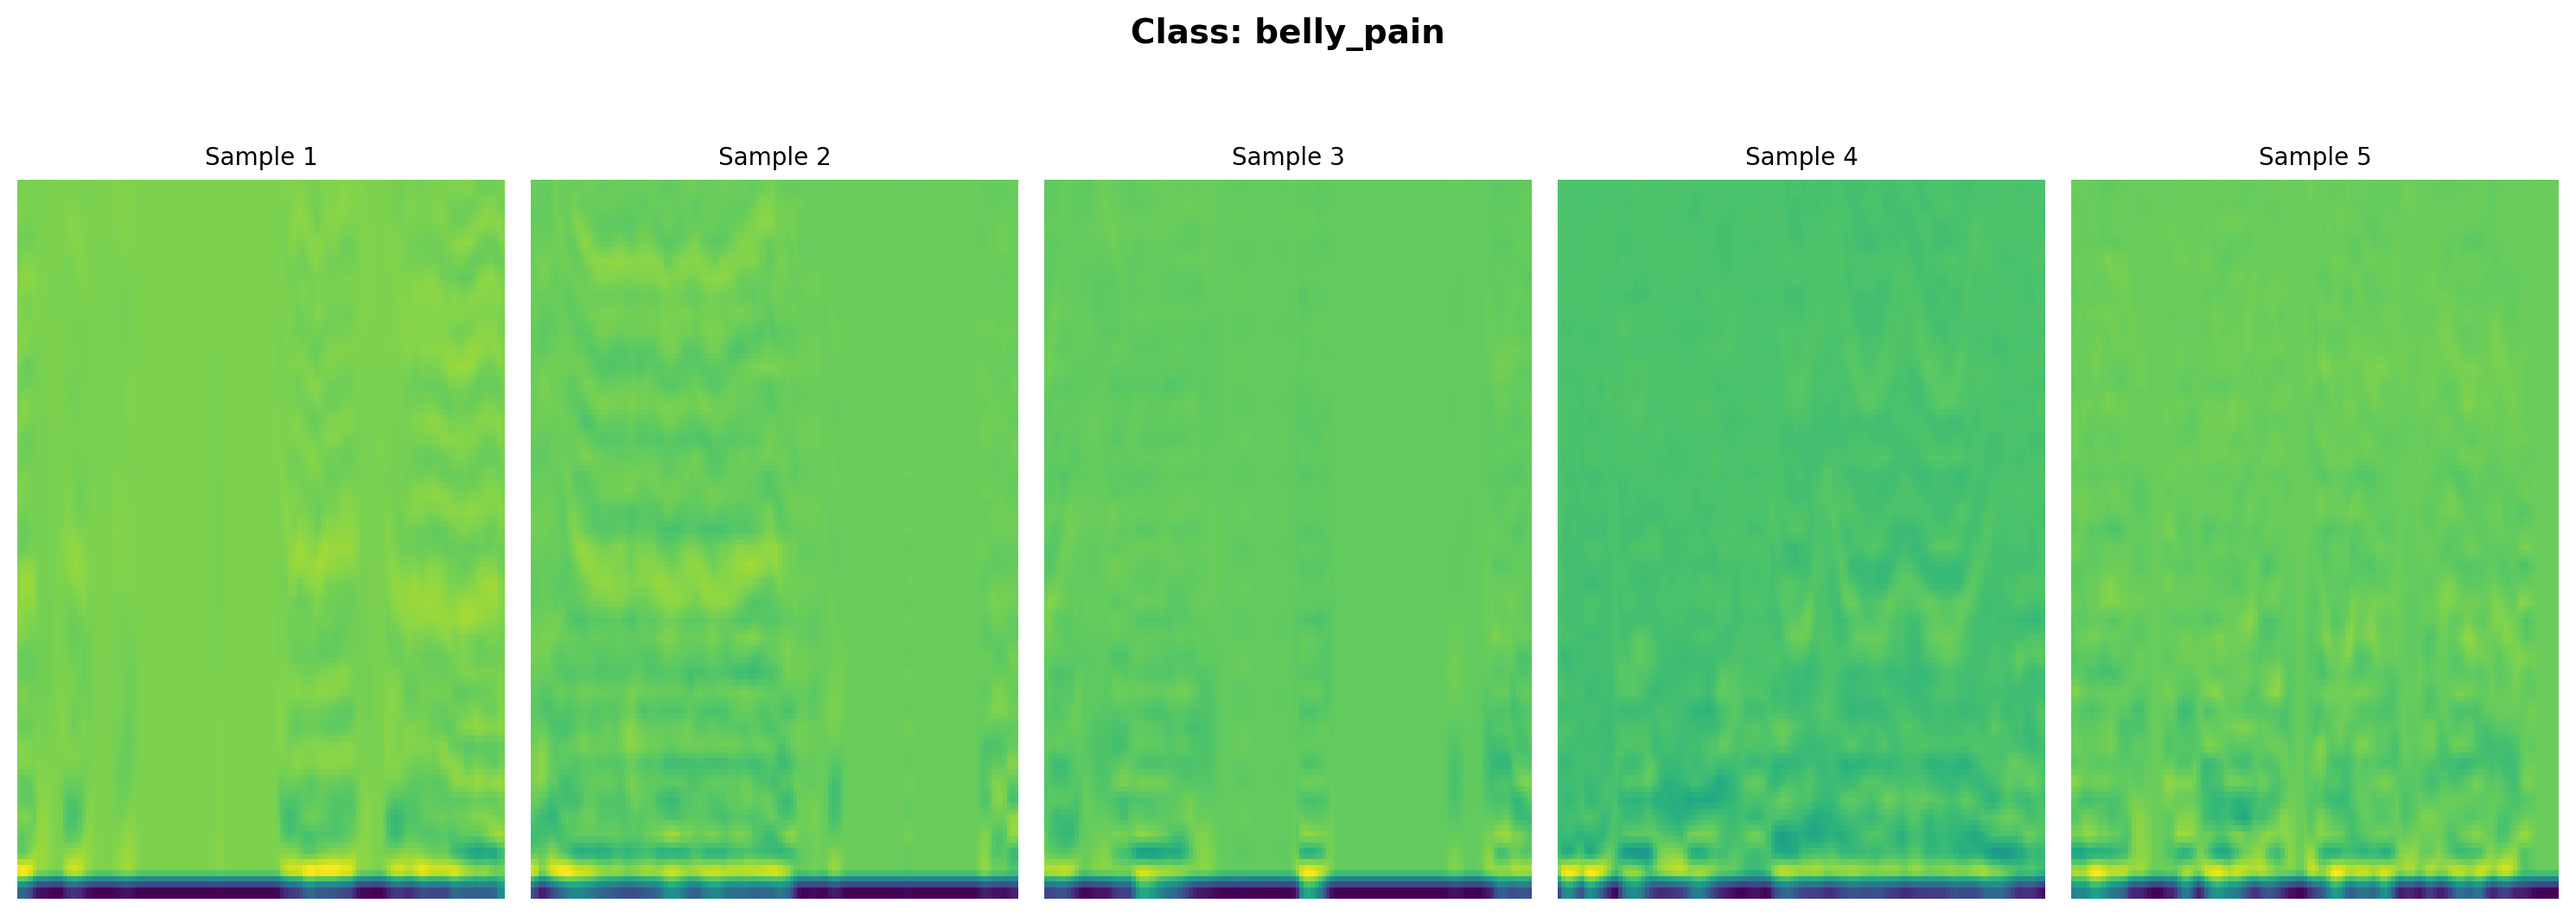

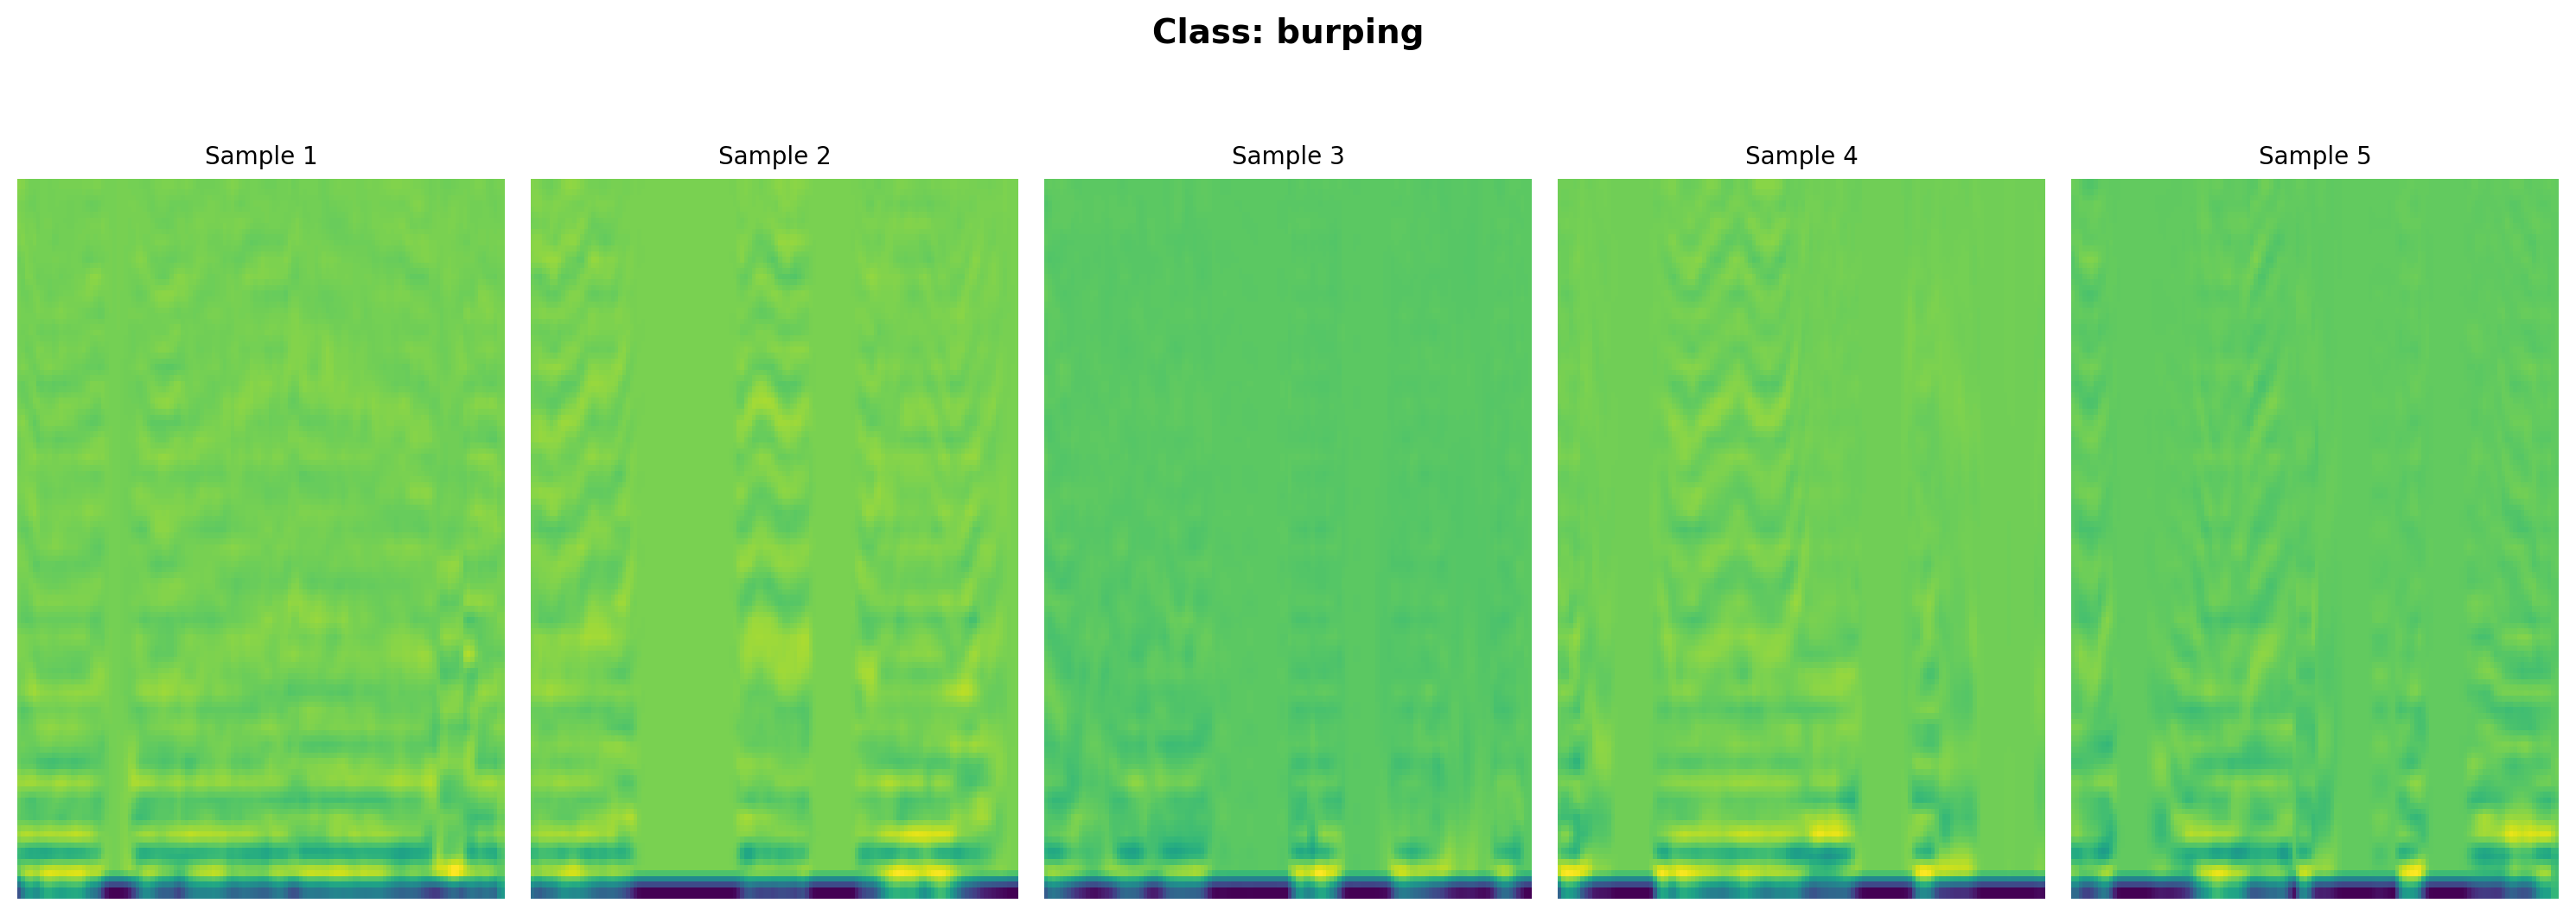

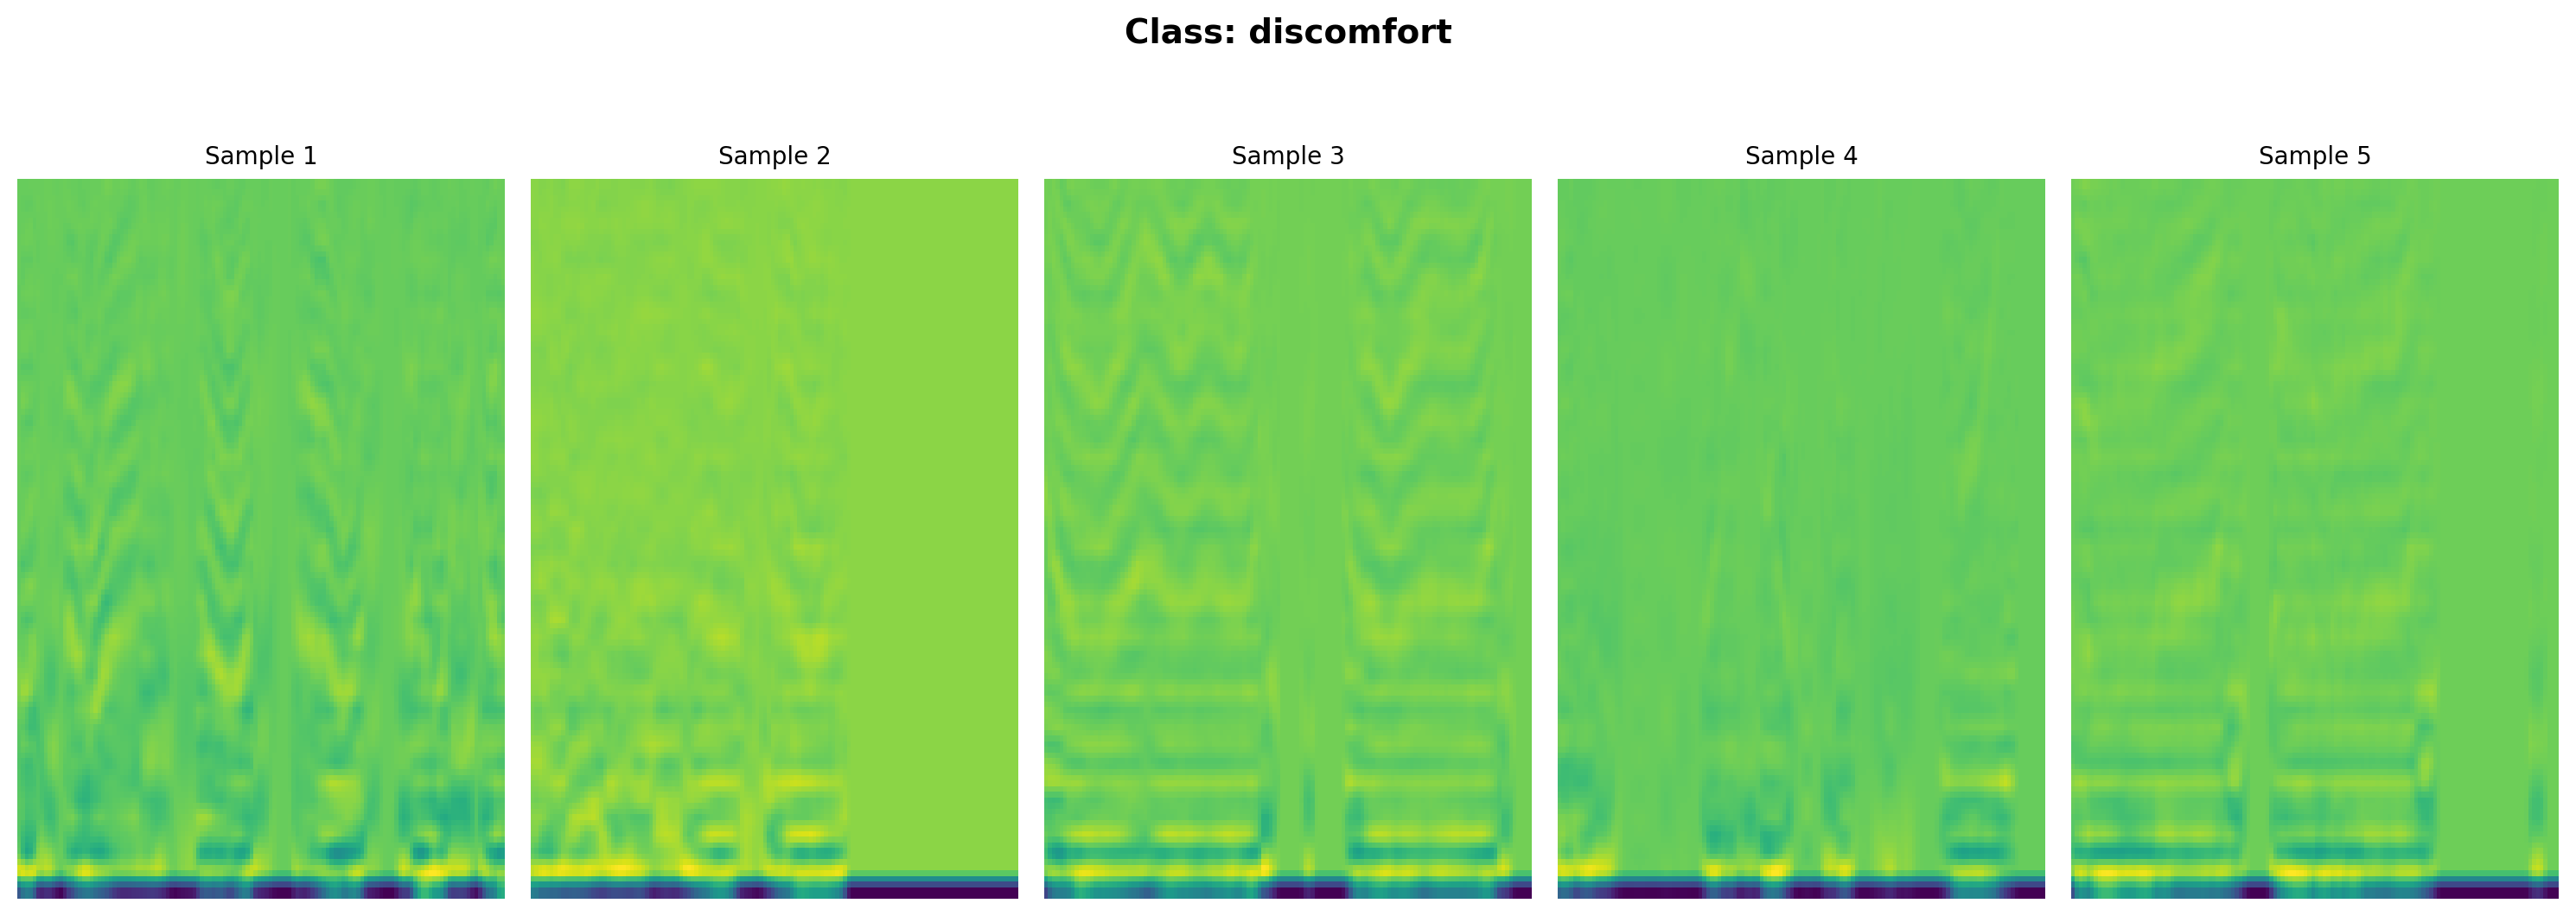

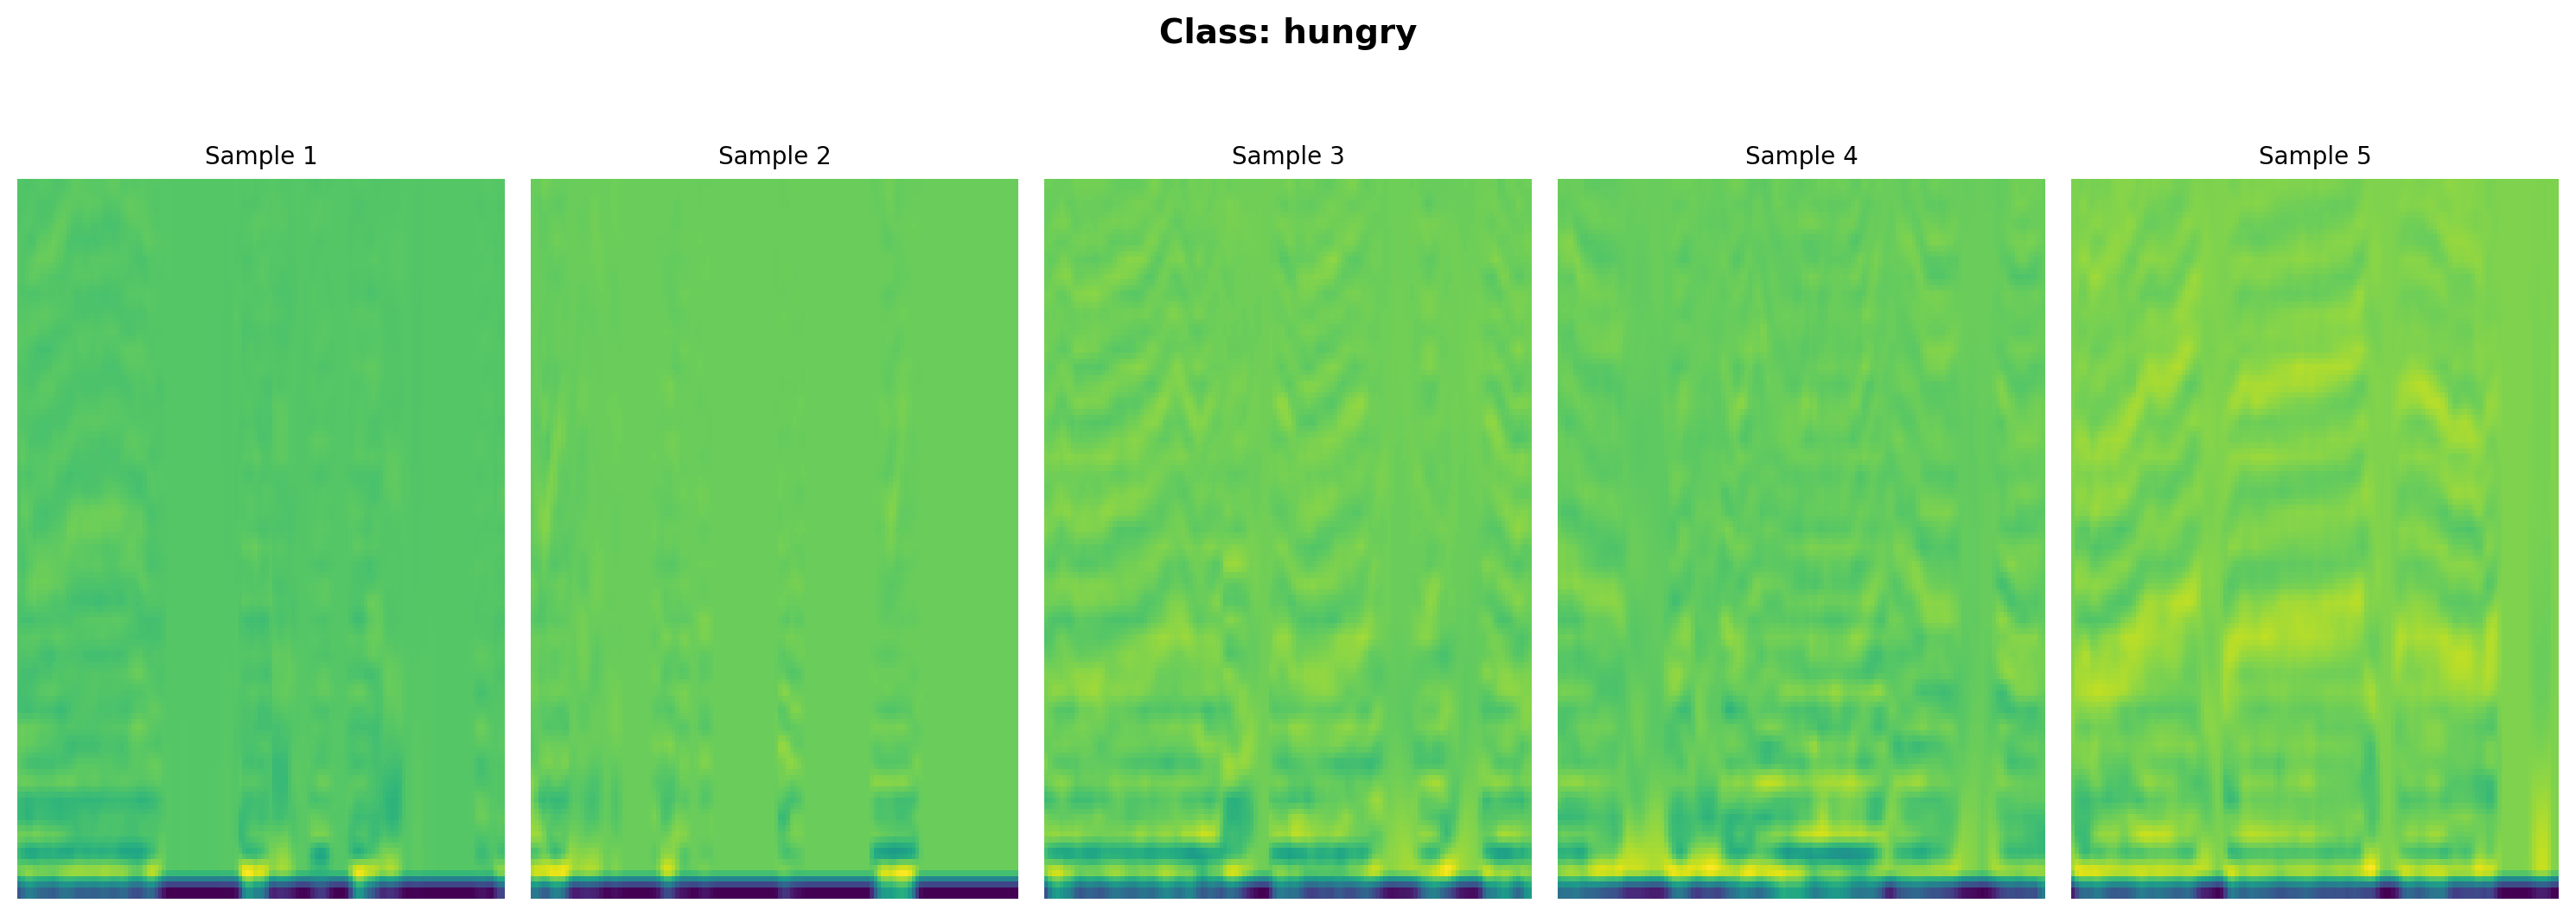

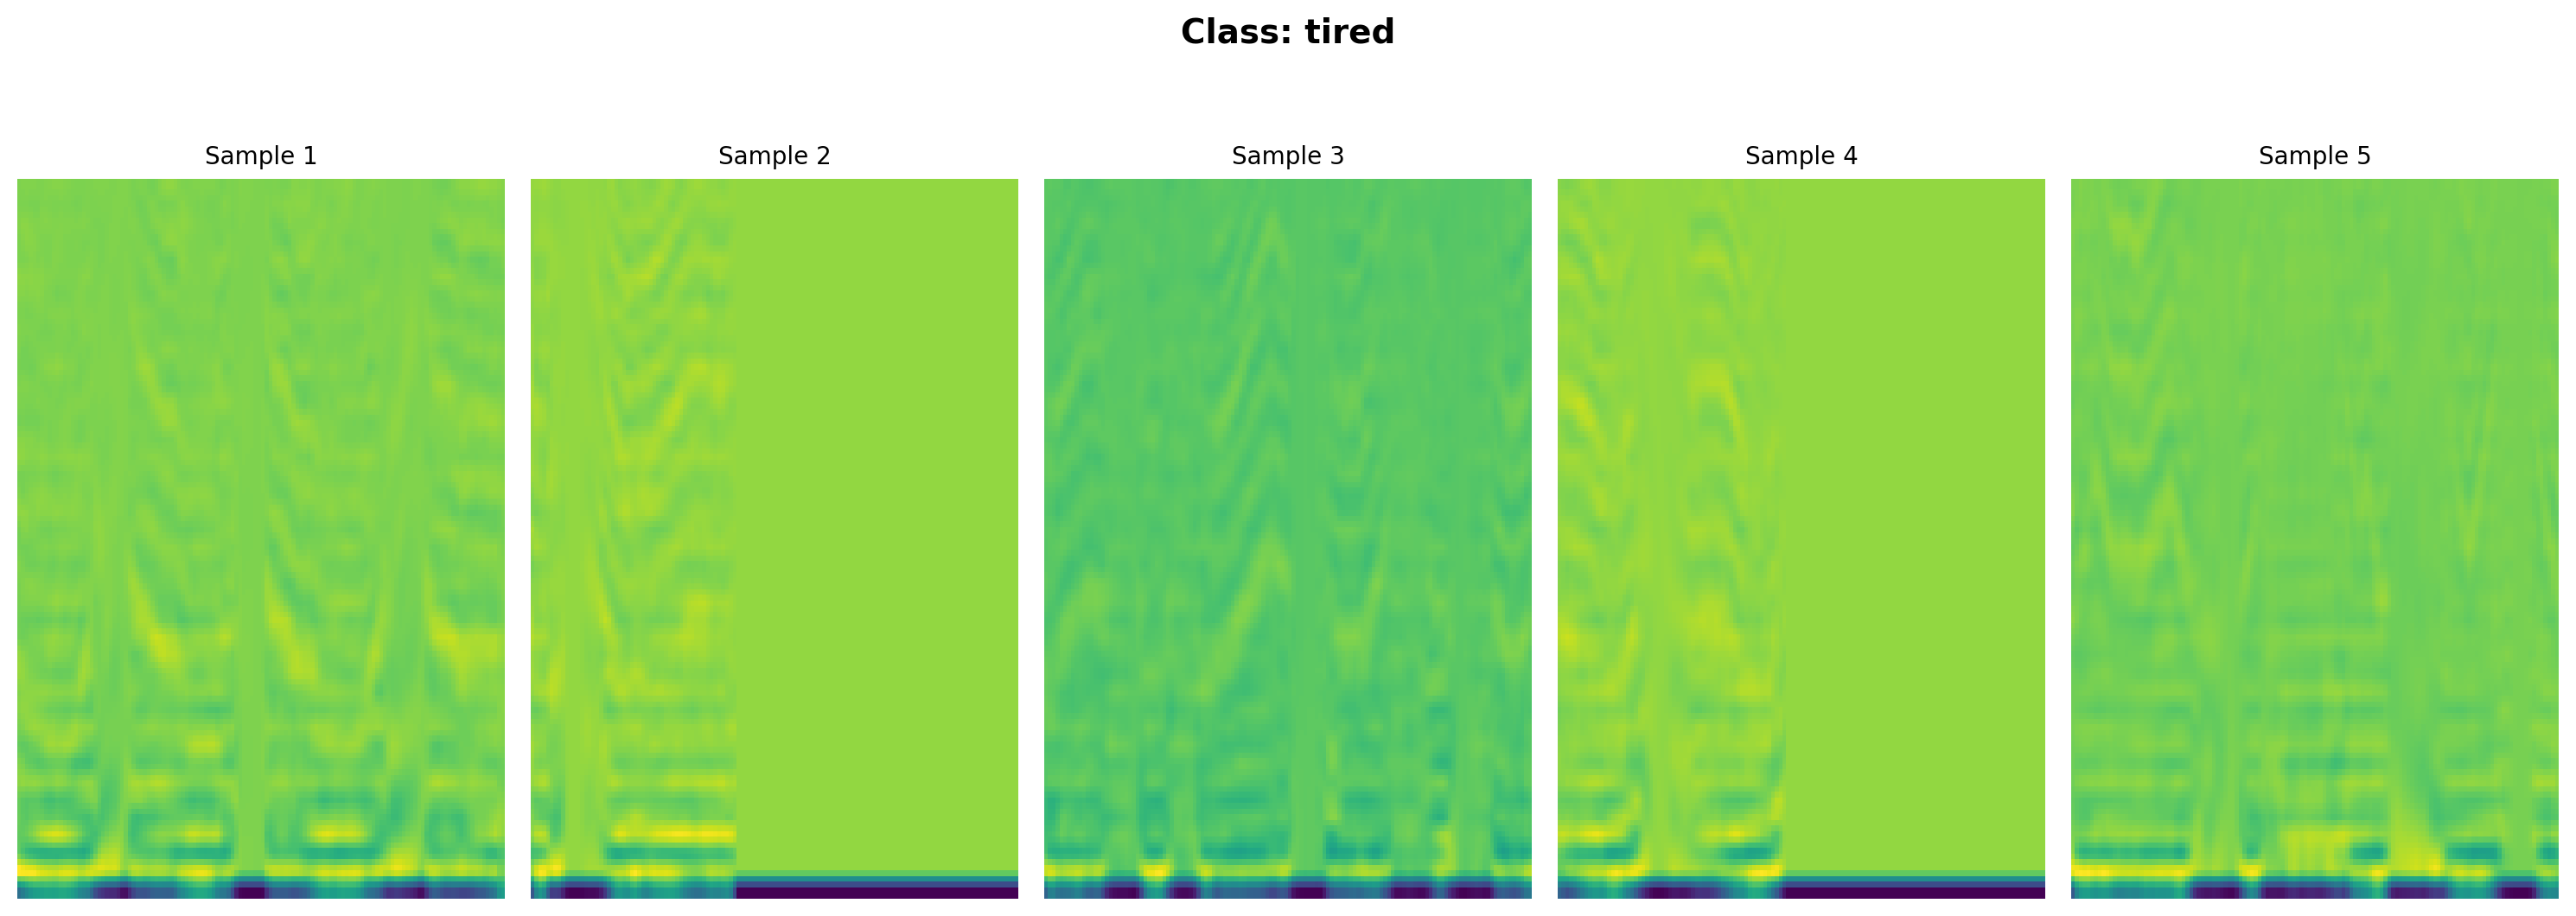

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os


# Get class names
class_indices = np.argmax(y_onehot, axis=1)
class_names = le.inverse_transform(np.unique(class_indices))

# Directory to save MFCC plots
os.makedirs("class_mfccs", exist_ok=True)

# Plot settings
n_samples = 5
dpi = 200
cmap_style = 'viridis'  # MFCCs usually look good with viridis or coolwarm

# Loop through each class
for class_label in class_names:
    indices = [i for i, y in enumerate(y_onehot) if le.inverse_transform([np.argmax(y)])[0] == class_label]

    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples * 3, 5), dpi=dpi)
    fig.suptitle(f"Class: {class_label}", fontsize=14, weight='bold', y=1.05)

    for i in range(n_samples):
        ax = axes[i]
        mfcc_img = X[indices[i]].squeeze()  # shape: (128,128)
        ax.imshow(mfcc_img, origin='lower', aspect='auto', cmap=cmap_style)
        ax.set_title(f"Sample {i+1}", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"class_mfccs/{class_label}_mfccs.png", bbox_inches='tight')
    plt.show()


## Class Balancing

In [18]:
X, y = load_data(DATA_PATH)

# Encode labels
from imblearn.over_sampling import SMOTE
from collections import Counter

# Original shapes
print("Before balancing:", Counter(y))

# Flatten X to 2D for oversampling
nsamples, time_steps, num_mfcc = X.shape
X_flat = X.reshape((nsamples, time_steps * num_mfcc))

# Apply oversampling
ros = SMOTE()
X_resampled, y_resampled = ros.fit_resample(X_flat, y)

print("After balancing:", Counter(y_resampled))

# Reshape X back to 3D
X_balanced = X_resampled.reshape((-1, time_steps, num_mfcc))


le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)
y_onehot = tf.keras.utils.to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_onehot, test_size=0.2, random_state=42)

# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

Before balancing: Counter({'hungry': 348, 'discomfort': 26, 'tired': 20, 'belly_pain': 15, 'burping': 8})
After balancing: Counter({'belly_pain': 348, 'burping': 348, 'discomfort': 348, 'hungry': 348, 'tired': 348})


## Model Development

In [19]:
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
model = build_model(X_train.shape[1:], num_classes=y_onehot.shape[1])
model.summary()



C:\Users\mypc\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 38, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 98, 38, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 36, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 94, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 94, 34, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 204544)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      26,181,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,238,789 (100.09 MB)

 Trainable params: 26,238,469 (100.09 MB)

 Non-trainable params: 320 (1.25 KB)

In [21]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7230 - loss: 5.0103 - val_accuracy: 0.2069 - val_loss: 38.2072
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9804 - loss: 0.1417 - val_accuracy: 0.4741 - val_loss: 11.1243
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9825 - loss: 0.1840 - val_accuracy: 0.9138 - val_loss: 0.5870
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9789 - loss: 0.1115 - val_accuracy: 0.9770 - val_loss: 0.1126
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9800 - loss: 0.1100 - val_accuracy: 0.9856 - val_loss: 0.0799
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9902 - loss: 0.1229 - val_accuracy: 0.9856 - val_loss: 0.1203
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9858 - loss: 0.2612 - val_accuracy: 0.9741 - val_loss: 0.2927
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9724 - loss: 0.4828 - val_accuracy: 0.9713 - val_los

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.9935 - loss: 0.0219
Test Accuracy: 0.99


In [23]:
from sklearn.metrics import classification_report
import numpy as np

# Get predicted class indices
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true class indices
y_true = np.argmax(y_test, axis=1)
target_names = le.inverse_transform(np.unique(y_true))  # original class labels
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step
              precision    recall  f1-score   support

  belly_pain       0.97      1.00      0.99        71
     burping       1.00      1.00      1.00        73
  discomfort       0.98      1.00      0.99        65
      hungry       1.00      0.96      0.98        72
       tired       1.00      1.00      1.00        67

    accuracy                           0.99       348
   macro avg       0.99      0.99      0.99       348
weighted avg       0.99      0.99      0.99       348



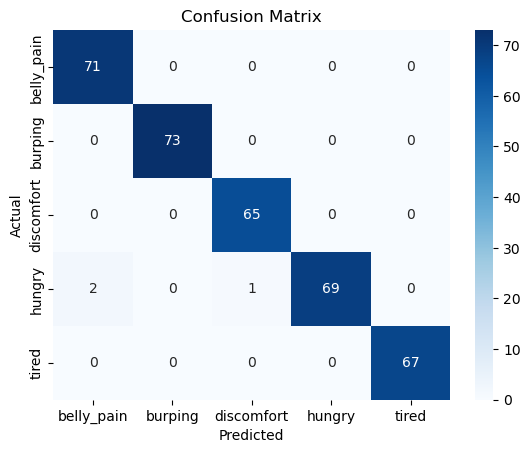

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

# Plot with blue color map
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


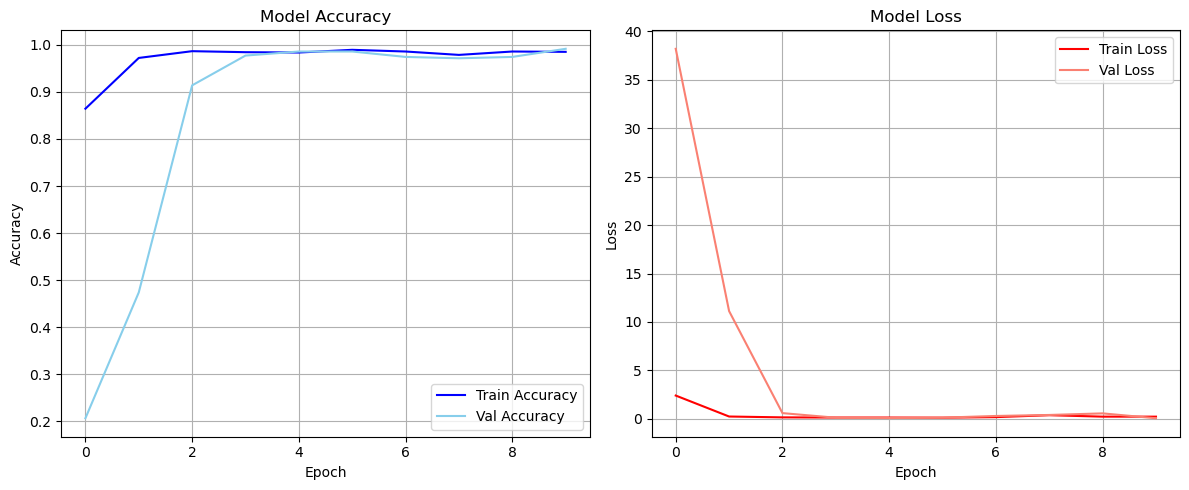

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='skyblue')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='salmon')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Model Saving

In [27]:
model.save("cry_classification_mfcc_model.h5")
